In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [2]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.2
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [3]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,transform=data_transforms['test']),
    batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Check Images

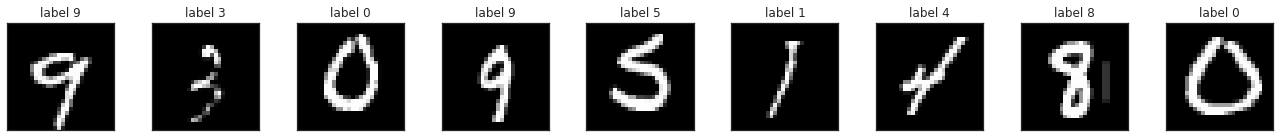

In [4]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
   
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

## LetNet : *Teacher Model*

=======> Teacher model trained with Temperature 20, Dropout 0.2
16:19:56 --- Epoch: 0	Train loss: 0.7923	Valid loss: 0.1877	Train accuracy: 91.69	Valid accuracy: 95.14
16:20:13 --- Epoch: 1	Train loss: 0.2461	Valid loss: 0.1193	Train accuracy: 94.40	Valid accuracy: 96.42
16:20:31 --- Epoch: 2	Train loss: 0.1783	Valid loss: 0.0919	Train accuracy: 95.95	Valid accuracy: 97.05
16:20:49 --- Epoch: 3	Train loss: 0.1483	Valid loss: 0.0730	Train accuracy: 96.72	Valid accuracy: 97.67
16:21:07 --- Epoch: 4	Train loss: 0.1272	Valid loss: 0.0688	Train accuracy: 96.86	Valid accuracy: 97.81
16:21:24 --- Epoch: 5	Train loss: 0.1127	Valid loss: 0.0643	Train accuracy: 97.24	Valid accuracy: 98.02
16:21:42 --- Epoch: 6	Train loss: 0.1064	Valid loss: 0.0636	Train accuracy: 97.40	Valid accuracy: 98.14
16:22:00 --- Epoch: 7	Train loss: 0.0954	Valid loss: 0.0555	Train accuracy: 97.78	Valid accuracy: 98.51
16:22:18 --- Epoch: 8	Train loss: 0.0899	Valid loss: 0.0488	Train accuracy: 97.81	Valid accuracy: 98.54


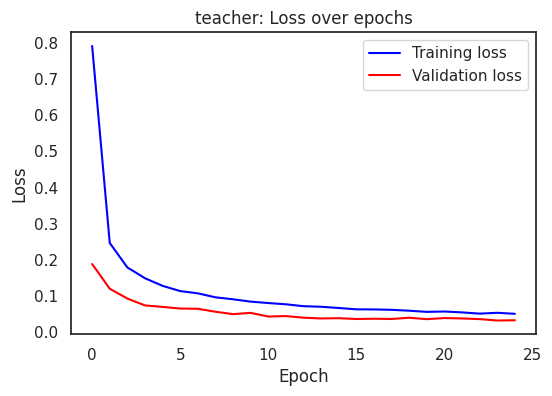

In [6]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature

    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


# Train
print(f"=======> Teacher model trained with Temperature {TEMP}, Dropout {DROPOUT}")
LEARNING_RATE = 0.01
N_EPOCHS = 25

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
          "prefix": "teacher",
          "title": "teacher"
         }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT) 

## Small Model : *Student Model*

=======> Student model
16:27:19 --- Epoch: 0	Train loss: 0.7850	Valid loss: 0.1795	Train accuracy: 91.45	Valid accuracy: 95.01
16:27:37 --- Epoch: 1	Train loss: 0.2294	Valid loss: 0.1286	Train accuracy: 94.53	Valid accuracy: 95.99
16:27:54 --- Epoch: 2	Train loss: 0.1621	Valid loss: 0.0935	Train accuracy: 95.95	Valid accuracy: 97.29
16:28:12 --- Epoch: 3	Train loss: 0.1311	Valid loss: 0.0910	Train accuracy: 95.99	Valid accuracy: 97.19
16:28:30 --- Epoch: 4	Train loss: 0.1136	Valid loss: 0.0705	Train accuracy: 96.92	Valid accuracy: 97.74
16:28:48 --- Epoch: 5	Train loss: 0.0998	Valid loss: 0.0723	Train accuracy: 96.85	Valid accuracy: 97.63
16:29:06 --- Epoch: 6	Train loss: 0.0887	Valid loss: 0.0661	Train accuracy: 97.10	Valid accuracy: 97.81
16:29:23 --- Epoch: 7	Train loss: 0.0846	Valid loss: 0.0551	Train accuracy: 97.71	Valid accuracy: 98.15
16:29:41 --- Epoch: 8	Train loss: 0.0774	Valid loss: 0.0479	Train accuracy: 97.78	Valid accuracy: 98.63
16:29:59 --- Epoch: 9	Train loss: 0.0724	

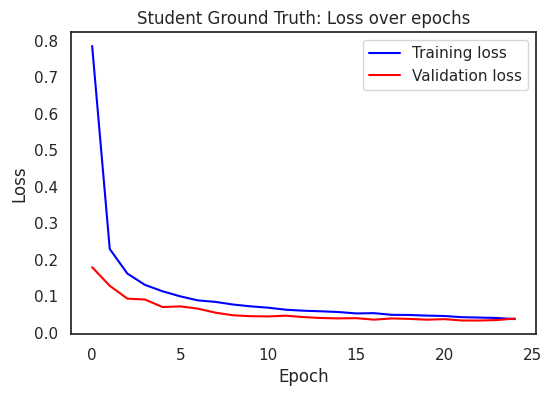

In [7]:
class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


# Train
LEARNING_RATE = 0.01
N_EPOCHS = 25

print(f"=======> Student model")
model_s = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

## Compare FLOP

In [8]:
!pip install thop
!pip install torchsummary

In [9]:
from thop import profile
from torchsummary import summary

print("teacher model summary:")
teacher_model = LargeNet(N_CLASSES).to(DEVICE)
summary(teacher_model, (1, 28, 28))
flops, params = profile(teacher_model, inputs=torch.rand(1,1,28,28).to(DEVICE))
print(f"FLOPS: {flops}, Params: {params}")

print("\nstudent model summary:")
student_model = SmallNet(N_CLASSES).to(DEVICE)
summary(student_model, (1, 28, 28))
flops, params = profile(student_model, inputs=torch.rand(1,1,28,28).to(DEVICE))
print(f"FLOPS: {flops}, Params: {params}")

teacher model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1200]         942,000
              ReLU-2                 [-1, 1200]               0
           Dropout-3                 [-1, 1200]               0
            Linear-4                 [-1, 1200]       1,441,200
              ReLU-5                 [-1, 1200]               0
           Dropout-6                 [-1, 1200]               0
            Linear-7                   [-1, 10]          12,010
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 9.14
Estimated Total Size (MB): 9.19
----------------------------------------------------------------
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[I